# Inicio

El objetivo del proyecto es predecir aquellos clientes con mayor propensión a abrir un mail de marketing sobre la adquisición de tarjetas de crédito por parte de una entidad bancaria

Para eso se utilizarán datos históricos para el entrenamiento

Negocio nos dice que tuvo un equipo de científicos previamente que obtuvo unas métricas que pueden verse a continuación. Sugiere que deberíamos intentar conseguir, al menos, algo similar.

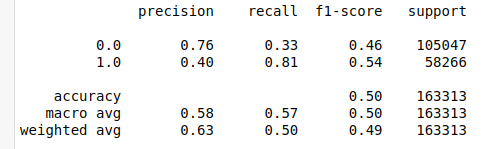

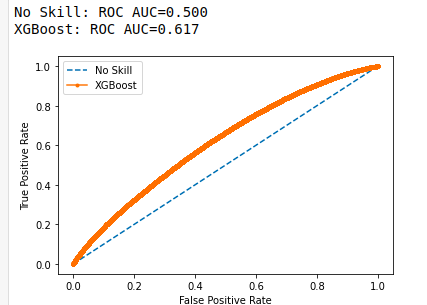

# Análisis Exploratorio de Datos

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from datetime import datetime
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
def calculate_roc(testy,lr_probs):
    # calculate scores
    ns_probs = [0 for _ in range(len(testy))]
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Carga del Dataset

In [182]:
df = pd.read_csv('/home/mgarcia/Documents/Study/DiploDatos/Repositories/G7/DiploDataScienceG7/Mauri/TP2/DatasetModulo2.csv')

In [4]:
pd.set_option('display.max_columns',500)

## Análisis Inicial del Dataset y Target

In [183]:
df.shape

(494887, 41)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494887 entries, 0 to 494886
Data columns (total 41 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   FechaSaldos                    494887 non-null  object 
 1   periodo_cli                    494887 non-null  int64  
 2   periodo                        494887 non-null  int64  
 3   cant_productos                 494887 non-null  int64  
 4   cant_PF                        494887 non-null  int64  
 5   cant_TC                        494887 non-null  int64  
 6   cant_PP                        494887 non-null  int64  
 7   FechaUltMovCA                  468164 non-null  object 
 8   cant_seguros                   494887 non-null  int64  
 9   importe_consumos               494887 non-null  int64  
 10  Edad                           494887 non-null  int64  
 11  Sexo                           494887 non-null  object 
 12  SaldoPromedioCAPesos          

In [6]:
df.target.value_counts(normalize=True)

0.0    0.993797
1.0    0.006203
Name: target, dtype: float64

In [7]:
df.target2.value_counts(normalize=True)

0.0    0.643668
1.0    0.356332
Name: target2, dtype: float64

## Análisis de Valores Nulos, Faltantes, erróneos

In [8]:
df.Sexo.value_counts(dropna=False)

F    277632
M    215313
       1942
Name: Sexo, dtype: int64

In [9]:
df.Sexo = df.Sexo.str.replace(' ','Na')

In [10]:
[col for col in df.columns if df[col].isna().any()==True]

['FechaUltMovCA',
 'FechaVinculacion',
 'SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2',
 'score_deuda']

In [11]:
df.score_deuda.fillna(0,inplace=True)

In [12]:
df.CategoriaProducto.value_counts(normalize=True,dropna=False)

14    0.517437
10    0.208884
12    0.177483
28    0.031868
19    0.020118
18    0.015377
3     0.007640
15    0.004710
9     0.002942
26    0.002762
27    0.002754
22    0.002750
7     0.001473
16    0.001113
6     0.000705
23    0.000430
13    0.000309
25    0.000299
20    0.000293
17    0.000228
5     0.000133
11    0.000109
1     0.000079
4     0.000034
24    0.000024
8     0.000016
2     0.000012
21    0.000010
0     0.000004
Name: CategoriaProducto, dtype: float64

In [13]:
to_keep = df.CategoriaProducto.value_counts(normalize=True,dropna=False)[:3].index

In [14]:
to_keep

Int64Index([14, 10, 12], dtype='int64')

In [15]:
df.CategoriaProducto.fillna('OTH',inplace=True)

In [16]:
df.CategoriaProducto = df.CategoriaProducto.apply(lambda x:'OTH' if x not in to_keep else x)

In [17]:
df.CategoriaProducto.value_counts()

14     256073
10     103374
12      87834
OTH     47606
Name: CategoriaProducto, dtype: int64

In [18]:
df.FechaSaldos = pd.to_datetime(df.FechaSaldos)

In [19]:
df.FechaUltMovCA = pd.to_datetime(df.FechaUltMovCA)

In [20]:
df.FechaVinculacion = pd.to_datetime(df.FechaVinculacion)

In [21]:
df[df.FechaVinculacion.isna()]['target2'].value_counts()

0.0    46403
1.0    32861
Name: target2, dtype: int64

In [22]:
df[df.FechaUltMovCA.isna()]['target2'].value_counts()

0.0    15337
1.0    11386
Name: target2, dtype: int64

In [23]:
df.target2.value_counts()

0.0    318543
1.0    176344
Name: target2, dtype: int64

In [24]:
df.FechaUltMovCA.mode()

0   2019-12-05
dtype: datetime64[ns]

In [25]:
df['FechaUltMovCA'].describe()

count                  468164
unique                    971
top       2019-12-05 00:00:00
freq                   101996
first     2004-04-19 00:00:00
last      2020-02-06 00:00:00
Name: FechaUltMovCA, dtype: object

In [26]:
df.loc[df.FechaUltMovCA.isna(),'FechaUltMovCA']=pd.to_datetime('2019-09-20')

In [27]:
(df.FechaVinculacion.dt.year - datetime.now().year)

0        -3.0
1        -5.0
2         NaN
3         NaN
4         NaN
         ... 
494882   -6.0
494883   -4.0
494884   -2.0
494885   -2.0
494886   -1.0
Name: FechaVinculacion, Length: 494887, dtype: float64

In [28]:
df['antiguedad']=(df.FechaVinculacion.dt.year - datetime.now().year)*-1

In [29]:
df.loc[df['antiguedad'].isna(),'antiguedad']=df.antiguedad.mean()

In [30]:
df.drop(columns='FechaVinculacion',inplace=True)

In [31]:
[col for col in df.columns if df[col].isna().any()==True]

['SaldoPromedioCAPesos_ant_1',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCCAcreedor_ant_1',
 'TotalConsumoTD_ant_1',
 'SaldoPromedioCAPesos_ant_2',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCCAcreedor_ant_2',
 'TotalConsumoTD_ant_2']

In [32]:
df.fillna(0,inplace=True)

In [33]:
df.drop(columns='target',inplace=True)

## Chequeo outliers

In [34]:
for col in df.select_dtypes('number').columns:
    print(col,sum(df[col]>df[col].quantile(0.95)))

periodo_cli 14014
periodo 14014
cant_productos 14527
cant_PF 12685
cant_TC 10671
cant_PP 10084
cant_seguros 23866
importe_consumos 355
Edad 24146
SaldoPromedioCAPesos 24745
SaldoPromedioCADolares 24745
SaldoPromedioCCAcreedor 18656
TotalConsumoTD 24745
TipoCuentaAcredHab 0
cuotas_faltantes_1 24386
cant_PF_ant_1 11187
cant_TC_ant_1 10503
cant_PP_ant_1 10318
SaldoPromedioCAPesos_ant_1 24745
SaldoPromedioCADolares_ant_1 24745
SaldoPromedioCCAcreedor_ant_1 18549
importe_consumos_ant_1 328
TotalConsumoTD_ant_1 24745
cuotas_faltantes 24676
cant_PF_ant_2 9425
cant_TC_ant_2 10371
cant_PP_ant_2 9729
SaldoPromedioCAPesos_ant_2 24745
SaldoPromedioCADolares_ant_2 24745
SaldoPromedioCCAcreedor_ant_2 18504
importe_consumos_ant_2 323
TotalConsumoTD_ant_2 24745
cuotas_faltantes_2 24685
score_deuda 10107
target2 0
antiguedad 16655


## Estudio de Distribución individual de los datos

In [35]:
all(df.periodo == df.periodo_cli)

True

In [36]:
df.drop(columns='periodo',inplace=True)

In [37]:
df[df.Edad<=18]['target2'].value_counts()

0.0    911
1.0    695
Name: target2, dtype: int64

In [38]:
df=df[df.Edad>18].copy()

In [39]:
df.shape

(493281, 39)

In [40]:
[col for col in df.columns if df[col].nunique()==1]

['TipoCuentaAcredHab']

In [41]:
df.drop(columns=[col for col in df.columns if df[col].nunique()==1],inplace=True)

In [42]:
df.drop(columns=['FechaSaldos','periodo_cli'],inplace=True)

### Uds ya tienen claro esto :)

## Ingeniería de Variables

### Variables Continuas

#### Calcular media, std, min, max, suma. Esto es por fila entre los períodos, es decir, por ejemplo, cálculo de esos datos para los montos que incluyen _1 y _2. Dejarlas como columnas adicionales.

In [43]:
for col in df.columns:
    if col+'_ant_1' in df.columns:
        print("Calculating %s" % col)
        df[col+'_mean']=df[[col,col+'_ant_1',col+'_ant_2']].mean(axis=1)
        df[col+'_std']=df[[col,col+'_ant_1',col+'_ant_2']].std(axis=1)
        df[col+'_min']=df[[col,col+'_ant_1',col+'_ant_2']].min(axis=1)
        df[col+'_max']=df[[col,col+'_ant_1',col+'_ant_2']].max(axis=1)
        df[col+'_TasaNew']=df[col].div(df[col+'_ant_1'])
        df[col+'_TasaOld']=df[col].div(df[col+'_ant_2'])

Calculating cant_PF
Calculating cant_TC
Calculating cant_PP
Calculating importe_consumos
Calculating SaldoPromedioCAPesos
Calculating SaldoPromedioCADolares
Calculating SaldoPromedioCCAcreedor
Calculating TotalConsumoTD


In [44]:
df.shape

(493281, 84)

In [45]:
df.columns

Index(['cant_productos', 'cant_PF', 'cant_TC', 'cant_PP', 'FechaUltMovCA',
       'cant_seguros', 'importe_consumos', 'Edad', 'Sexo',
       'SaldoPromedioCAPesos', 'SaldoPromedioCADolares',
       'SaldoPromedioCCAcreedor', 'TotalConsumoTD', 'CategoriaProducto',
       'cuotas_faltantes_1', 'cant_PF_ant_1', 'cant_TC_ant_1', 'cant_PP_ant_1',
       'SaldoPromedioCAPesos_ant_1', 'SaldoPromedioCADolares_ant_1',
       'SaldoPromedioCCAcreedor_ant_1', 'importe_consumos_ant_1',
       'TotalConsumoTD_ant_1', 'cuotas_faltantes', 'cant_PF_ant_2',
       'cant_TC_ant_2', 'cant_PP_ant_2', 'SaldoPromedioCAPesos_ant_2',
       'SaldoPromedioCADolares_ant_2', 'SaldoPromedioCCAcreedor_ant_2',
       'importe_consumos_ant_2', 'TotalConsumoTD_ant_2', 'cuotas_faltantes_2',
       'score_deuda', 'target2', 'antiguedad', 'cant_PF_mean', 'cant_PF_std',
       'cant_PF_min', 'cant_PF_max', 'cant_PF_TasaNew', 'cant_PF_TasaOld',
       'cant_TC_mean', 'cant_TC_std', 'cant_TC_min', 'cant_TC_max',
       'ca

### Variables Categóricas

#### Transformar variables Categóricas Nominales a matríz de unos y ceros

In [46]:
df.select_dtypes(exclude='number')

,FechaUltMovCA,Sexo,CategoriaProducto
0,2019-12-02,M,12
1,2019-12-04,F,12
2,2019-12-05,F,12
3,2019-12-05,F,12
4,2019-12-05,F,14
...,...,...,...
494804,2020-02-06,Na,OTH
494845,2020-02-06,Na,OTH
494872,2020-02-06,Na,OTH
494873,2019-09-23,Na,OTH


In [47]:
df = pd.concat([df,pd.get_dummies(df.Sexo),pd.get_dummies(df.CategoriaProducto)],axis=1)

In [48]:
df.drop(columns=['Sexo','CategoriaProducto'],inplace=True)

In [49]:
(df.FechaUltMovCA.dt.date - datetime(2020,2,10).date()).dt.days

0         -70
1         -68
2         -67
3         -67
4         -67
         ... 
494804     -4
494845     -4
494872     -4
494873   -140
494881     -4
Name: FechaUltMovCA, Length: 493281, dtype: int64

In [50]:
df['DiasDesdeMov']=((df.FechaUltMovCA.dt.date - datetime(2020,2,10).date())*-1).dt.days

In [51]:
df['DiasDesdeMov'].fillna(-999,inplace=True)

#### Transformar variables Categóricas Ordinales con Label Encoding

In [52]:
df.drop(columns=['FechaUltMovCA'],inplace=True)

In [53]:
df.fillna(0,inplace=True)

# Modelado

## Trabajar las variables para ingresar al modelo. Seleccionar método de escalado (ver StandardScaler, MinMaxScaler, etc) y elegir uno o probar varios

In [54]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

# Sampleo para poder trabajar más rápido...

In [55]:
df = df.sample(frac=0.02, random_state=311)

In [56]:
df.shape

(9866, 89)

In [57]:
y = df.target2

In [58]:
df.describe()

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCADolares,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCADolares_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,target2,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCADolares_mean,SaldoPromedioCADolares_std,SaldoPromedioCADolares_min,SaldoPromedioCADolares_max,SaldoPromedioCADolares_TasaNew,SaldoPromedioCADolares_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
count,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.00000,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9.866000e+03,9.866000e+03,9.866000e+03,9.866000e+03,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.00000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.0,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000
mean,3.429455,0.137543,1.320697,0.196331,0.431887,14.140482,49.31340,3.893733e+04,676.093262,873.813456,5511.208107,9.287249,0.128015,1.314920,0.195216,3.392077e+04,714.643024,735.101224,15.740320,4573.691519,9.215285,0.106021,1.309041,0.199068,3.265600e+04,745.008278,688.614715,16.276607,4386.303737,9.429759,0.764139,0.352828,8.301862,0.123860,0.060784,0.073282,0.181938,inf,inf,1.314886,0.024305,1.293128,1.335496,inf,inf,0.196871,0.020185,0.180519,0.215589,inf,inf,15.385803,3.326141,12.201297,18.545814,0.000791,0.000922,3.517137e+04,1.066347e+04,2.576489e+04,4.601224e+04,inf,inf,711.914854,159.913613,570.503829,866.998406,inf,inf,765.843132,270.183897,535.772212,1046.977240,inf,inf,4823.734454,2430.752387,2734.743947,7317.298964,inf,inf,0.568011,0.430874,0.001115,0.203325,0.174843,0.524326,0.097507,184.112508
std,1.822242,0.629592,1.185198,0.460361,0.868945,1027.124974,17.27902,1.166523e+05,5024.166812,16280.021951,10266.099529,29.321570,0.622709,1.177959,0.452734,1.109910e+05,5069.637213,13293.114471,1262.985743,9032.295894,29.181097,0.499275,1.179085,0.455971,1.093094e+05,5133.348159,12899.911669,1376.784934,8405.502585,29.607491,0.553123,0.477874,5.106559,0.531338,0.299667,0.408726,0.759092,NaN,NaN,1.175426,0.135143,1.175449,1.187428,NaN,NaN,0.447446,0.108116,0.428519,0.485621,NaN,NaN,1219.649759,203.714492

In [59]:
df.columns = df.columns.astype(str)

In [60]:
colstoexclude=['target2']+[col for col in df.columns if 'Dolares' in col]

In [61]:
colstoexclude

['target2',
 'SaldoPromedioCADolares',
 'SaldoPromedioCADolares_ant_1',
 'SaldoPromedioCADolares_ant_2',
 'SaldoPromedioCADolares_mean',
 'SaldoPromedioCADolares_std',
 'SaldoPromedioCADolares_min',
 'SaldoPromedioCADolares_max',
 'SaldoPromedioCADolares_TasaNew',
 'SaldoPromedioCADolares_TasaOld']

In [62]:
X=df[[col for col in df.columns if col not in colstoexclude]]

In [63]:
X

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
369555,3,0,1,0,1,0,38,35515.80,0.0,5239.50,0,0,1,0,33868.02,0.0,0,1640.34,0,0,1,0,45717.28,0.0,0,9580.84,0,1.0,17.000000,0.000000,0.00000,0,0,0.0,0.0,1.000000,0.00000,1,1,1.0,1.000000,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,38367.033333,6418.597143,33868.02,45717.28,1.048653,0.776857,0.0,0.0,0.0,0.0,0.0,0.0,5486.893333,3976.026617,1640.34,9580.84,3.194155,0.546873,0,1,0,0,0,1,0,133
488556,3,0,0,0,0,0,42,84736.97,0.0,35751.88,0,1,0,0,90355.82,0.0,0,47374.87,0,1,0,0,79811.27,0.0,0,35826.48,0,1.0,4.000000,0.666667,0.57735,0,1,0.0,0.0,0.000000,0.00000,0,0,0.0,0.000000,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,84968.020000,5276.070674,79811.27,90355.82,0.937814,1.061717,0.0,0.0,0.0,0.0,0.0,0.0,39651.076667,6689.105238,35751.88,47374.87,0.754659,0.997918,0,1,0,0,0,0,1,4
327386,3,1,1,0,0,0,46,26822.32,0.0,0.00,0,1,1,0,14645.85,0.0,0,0.00,0,1,1,0,10875.06,0.0,0,0.00,0,1.0,14.000000,1.000000,0.00000,1,1,1.0,1.0,1.000000,0.00000,1,1,1.0,1.000000,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,17447.743333,8334.670363,10875.06,26822.32,1.831394,2.466407,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1,0,0,0,0,1,0,362
429900,3,0,1,0,0,0,25,0.00,0.0,0.00,0,0,1,0,0.00,0.0,0,0.00,0,0,1,0,0.00,0.0,0,0.00,0,1.0,3.000000,0.000000,0.00000,0,0,0.0,0.0,1.000000,0.00000,1,1,1.0,1.000000,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1,0,0,1,0,0,0,700
473739,2,0,1,0,0,0,90,84715.16,0.0,0.00,0,0,1,0,65570.09,0.0,0,0.00,0,0,1,0,160310.75,0.0,0,0.00,0,1.0,10.000000,0.000000,0.00000,0,0,0.0,0.0,1.000000,0.00000,1,1,1.0,1.000000,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,103532.000000,50094.942509,65570.09,160310.75,1.291979,0.528443,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1,0,0,0,1,0,0,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53014,7,0,5,0,0,0,53,565984.12,0.0,9879.38,0,0,5,0,502017.76,0.0,0,8656.46,0,0,6,0,414831.72,0.0,0,7306.99,0,1.0,10.000000,0.000000,0.00000,0,0,0.0,0.0,5.333333,0.57735,5,6,1.0,0.833333,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,494277.866667,75872.863845,414831.72,565984.12,1.127419,1.364370,0.0,0.0,0.0,0.0,0.0,0.0,8614.276667,1286.713703,7306.99,9879.38,1.141273,1.352045,0,1,0,0,0,1,0,68
467360,4,0,2,0,1,0,70,459193.87,0.0,46410.69,0,0,2,0,349023.10,0.0,0,11044.12,0,

In [64]:
X = X.replace([np.inf, -np.inf], 0)

In [65]:
from sklearn.preprocessing import RobustScaler

In [66]:
RobustScaler

sklearn.preprocessing._data.RobustScaler

In [67]:
scaler = RobustScaler()

In [68]:
X_scaled = scaler.fit_transform(X)

In [69]:
X_scaled=pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

In [70]:
X_scaled

,cant_productos,cant_PF,cant_TC,cant_PP,cant_seguros,importe_consumos,Edad,SaldoPromedioCAPesos,SaldoPromedioCCAcreedor,TotalConsumoTD,cuotas_faltantes_1,cant_PF_ant_1,cant_TC_ant_1,cant_PP_ant_1,SaldoPromedioCAPesos_ant_1,SaldoPromedioCCAcreedor_ant_1,importe_consumos_ant_1,TotalConsumoTD_ant_1,cuotas_faltantes,cant_PF_ant_2,cant_TC_ant_2,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,antiguedad,cant_PF_mean,cant_PF_std,cant_PF_min,cant_PF_max,cant_PF_TasaNew,cant_PF_TasaOld,cant_TC_mean,cant_TC_std,cant_TC_min,cant_TC_max,cant_TC_TasaNew,cant_TC_TasaOld,cant_PP_mean,cant_PP_std,cant_PP_min,cant_PP_max,cant_PP_TasaNew,cant_PP_TasaOld,importe_consumos_mean,importe_consumos_std,importe_consumos_min,importe_consumos_max,importe_consumos_TasaNew,importe_consumos_TasaOld,SaldoPromedioCAPesos_mean,SaldoPromedioCAPesos_std,SaldoPromedioCAPesos_min,SaldoPromedioCAPesos_max,SaldoPromedioCAPesos_TasaNew,SaldoPromedioCAPesos_TasaOld,SaldoPromedioCCAcreedor_mean,SaldoPromedioCCAcreedor_std,SaldoPromedioCCAcreedor_min,SaldoPromedioCCAcreedor_max,SaldoPromedioCCAcreedor_TasaNew,SaldoPromedioCCAcreedor_TasaOld,TotalConsumoTD_mean,TotalConsumoTD_std,TotalConsumoTD_min,TotalConsumoTD_max,TotalConsumoTD_TasaNew,TotalConsumoTD_TasaOld,F,M,Na,10,12,14,OTH,DiasDesdeMov
0,0.0,0.0,0.0,0.0,1.0,0.0,-0.32,0.586547,0.0,0.709224,0.0,0.0,0.0,0.0,0.760747,0.0,0.0,0.278901,0.0,0.0,0.0,0.0,1.223285,0.0,0.0,1.699875,0.0,0.0,1.253040,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.805952,0.280878,1.144689,0.665254,-0.061908,-0.320616,0.0,0.0,0.0,0.0,0.0,0.0,0.725271,1.091740,0.537767,0.788852,3.080789,0.530130,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.018868
1,0.0,0.0,-1.0,0.0,0.0,0.0,-0.16,1.985542,0.0,4.839408,0.0,1.0,-1.0,0.0,2.712729,0.0,0.0,8.054988,0.0,1.0,-1.0,0.0,2.427384,0.0,0.0,6.356493,0.0,0.0,-0.604103,0.666667,0.57735,0.0,1.0,0.0,0.0,-1.000000,0.00000,-1.0,-1.0,-1.0,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.308026,0.157637,3.222983,1.750205,-0.192188,-0.060810,0.0,0.0,0.0,0.0,0.0,0.0,5.702769,1.943107,11.720842,4.344119,0.727875,0.967366,-1.0,1.0,0.0,0.0,0.0,-1.0,1.0,-0.505660
2,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.339455,0.0,0.000000,0.0,1.0,0.0,0.0,0.096510,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,-0.007238,0.0,0.0,0.000000,0.0,0.0,0.824469,1.000000,0.00000,1.0,1.0,1.0,1.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131667,0.487561,0.104577,0.206006,0.858123,1.220337,0.0,0.0,0.0,0.0,0.0,0.0,-0.074134,-0.155943,0.000000,-0.112413,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.845283
3,0.0,0.0,0.0,0.0,0.0,0.0,-0.84,-0.422906,0.0,0.000000,0.0,0.0,0.0,0.0,-0.409589,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.391313,0.0,0.0,0.000000,0.0,0.0,-0.746960,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.430721,-0.411481,-0.387368,-0.445917,-1.294492,-1.029149,0.0,0.0,0.0,0.0,0.0,0.0,-0.074134,-0.155943,0.000000,-0.112413,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,-1.0,0.0,2.120755
4,-0.5,0.0,0.0,0.0,0.0,0.0,1.76,1.984922,0.0,0.000000,0.0,0.0,0.0,0.0,1.856238,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.270386,0.0,0.0,0.000000,0.0,0.0,0.253040,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.906393,4.992146,2.578768,3.450479,0.224096,-0.547182,0.0,0.0,0.0,0.0,0.0,0.0,-0.074134,-0.155943,0.000000,-0.112413,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.264151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9861,2.0,0.0,4.0,0.0,0.0,0.0,0.28,15.663854,0.0,1.33728

In [71]:
X = X_scaled.copy()

In [72]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=311)

### Random Forest

In [73]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
print(rfc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [74]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [75]:
y_preds=rfc.predict(X_test)

In [76]:
y_preds.shape

(2960,)

In [77]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.78      1905
         1.0       0.50      0.02      0.05      1055

    accuracy                           0.64      2960
   macro avg       0.57      0.51      0.41      2960
weighted avg       0.59      0.64      0.52      2960



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.505


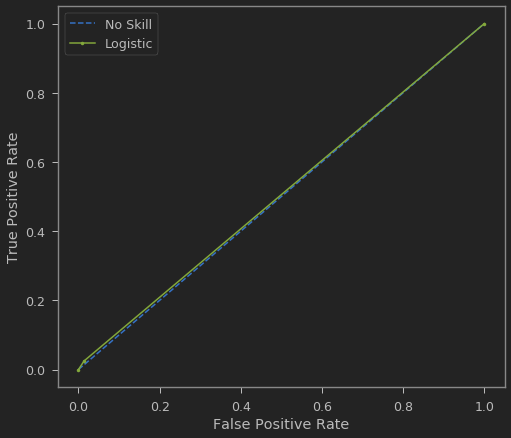

In [78]:
calculate_roc(y_test, y_preds)

In [79]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


### Random HyperParameter Grid

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [81]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='f1')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [82]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [83]:
rfc = RandomForestClassifier(**rf_random.best_params_)
print(rfc)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [84]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [85]:
y_preds = rfc.predict(X_test)
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

         0.0       0.66      0.87      0.75      1905
         1.0       0.46      0.19      0.27      1055

    accuracy                           0.63      2960
   macro avg       0.56      0.53      0.51      2960
weighted avg       0.59      0.63      0.58      2960



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.533


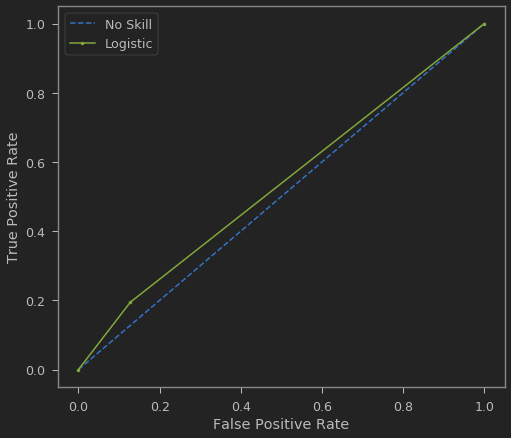

In [86]:
calculate_roc(y_test, y_preds)

## Modelo de regresión logística

In [87]:
from sklearn.linear_model import LogisticRegression

In [88]:
logreg_1 = LogisticRegression(solver='lbfgs',max_iter=1000)

In [89]:
logreg_1.fit(X_train,y_train)

/home/mgarcia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
y_preds_1 = logreg_1.predict_proba(X_test)

In [91]:
print(classification_report(y_test,y_preds_1[:,1]>0.5))

              precision    recall  f1-score   support

         0.0       0.65      0.90      0.76      1905
         1.0       0.42      0.13      0.20      1055

    accuracy                           0.63      2960
   macro avg       0.54      0.51      0.48      2960
weighted avg       0.57      0.63      0.56      2960



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.515


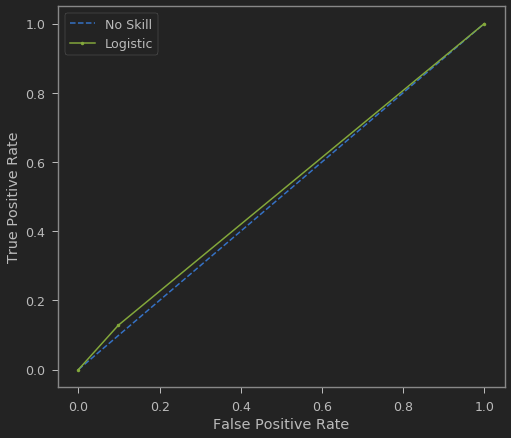

In [92]:
calculate_roc(y_test,y_preds_1[:,1]>0.5)

In [93]:
logreg = LogisticRegression(penalty='l2',solver='lbfgs',C=1 ,max_iter=1000)

In [94]:
logreg.fit(X_train,y_train)

/home/mgarcia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
y_preds = logreg.predict_proba(X_test)

In [96]:
param_grid = { 
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'C': [0.0001,0.001,0.01,0.1,1,10,100,1000]
}

In [97]:
CV_rfc = GridSearchCV(estimator=logreg, param_grid=param_grid, cv= 2,n_jobs=6, verbose=5, scoring='f1')

In [98]:
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done  48 out of  48 | elapsed:  1.2min finished
/home/mgarcia/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=2, error_score=nan,
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=6,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=5)

In [99]:
CV_rfc.best_params_

{'C': 0.1, 'solver': 'lbfgs'}

In [100]:
CV_rfc.best_estimator_.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [101]:
CV_rfc.best_estimator_.score(X_test,y_test)

0.6266891891891891

In [102]:
CV_rfc.best_score_

0.2402867161731082

In [103]:
CV_rfc.cv_results_

{'mean_fit_time': array([ 3.43784833,  0.44826174,  1.29365075,  3.17060566,  2.27138782,
         1.53700638,  2.63308203,  2.25571346,  1.80909753,  2.71305013,
         2.52090812,  4.6415863 ,  5.05149865,  4.51139009, 15.88165295,
         5.447528  ,  6.89155936, 24.42963994,  6.40552902,  5.90116096,
        29.84470081,  6.71095562,  5.46713567, 24.18554783]),
 'std_fit_time': array([1.84965134e-03, 2.62761593e-01, 1.14382386e-01, 9.75456238e-02,
        5.84355593e-01, 4.72416878e-02, 3.01728606e-01, 1.06834173e-01,
        5.03628254e-02, 1.06165409e-01, 9.80810642e-01, 9.00626183e-03,
        2.23568916e-01, 9.14077401e-01, 2.13100040e+00, 2.52949834e-01,
        2.03925228e+00, 1.26180041e+00, 3.04031610e-01, 2.13447499e+00,
        1.79155326e+00, 2.12515593e-01, 3.23603392e-01, 3.70253754e+00]),
 'mean_score_time': array([0.01099968, 0.0615356 , 0.01317012, 0.0201056 , 0.01240242,
        0.00946057, 0.00763476, 0.00724101, 0.00868559, 0.01875746,
        0.01580071, 0.01

In [104]:
print(classification_report(y_test,y_preds[:,1]>0.5))

              precision    recall  f1-score   support

         0.0       0.65      0.90      0.76      1905
         1.0       0.42      0.13      0.20      1055

    accuracy                           0.63      2960
   macro avg       0.54      0.51      0.48      2960
weighted avg       0.57      0.63      0.56      2960



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.515


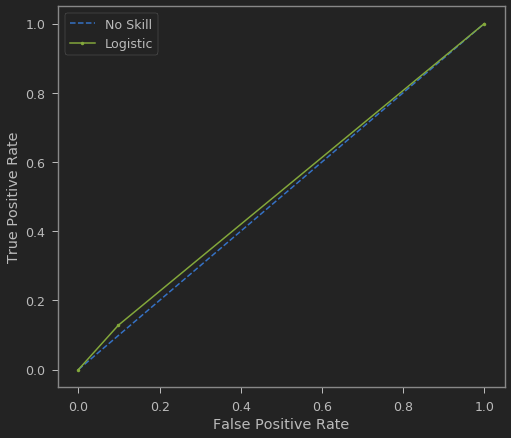

In [105]:
calculate_roc(y_test,y_preds[:,1]>0.5)

# K Nearest Neighbors (KNN)

In [106]:
from sklearn.neighbors import KNeighborsClassifier

Primero hacemos prueba con los siguientes parametros: n_neighbors=1, weights='distance'

In [107]:
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')

In [108]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [109]:
knn.score(X_test, y_test)

0.5601351351351351

In [110]:
X_train.shape

(6906, 79)

In [111]:
y_train.shape

(6906,)

In [112]:
X_test.shape

(2960, 79)

In [113]:
y_test.shape

(2960,)

In [114]:
y_pred = knn.predict_proba(X_test)

In [115]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.66      1905
         1.0       0.38      0.37      0.37      1055

    accuracy                           0.56      2960
   macro avg       0.52      0.52      0.52      2960
weighted avg       0.56      0.56      0.56      2960



In [116]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1270,  635],
       [ 667,  388]])

In [117]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')

In [118]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='distance')

In [119]:
knn.score(X_test, y_test)

0.5597972972972973

In [120]:
y_pred = knn.predict_proba(X_test)

In [121]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.66      1905
         1.0       0.38      0.37      0.37      1055

    accuracy                           0.56      2960
   macro avg       0.52      0.52      0.52      2960
weighted avg       0.56      0.56      0.56      2960



In [122]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1270,  635],
       [ 668,  387]])

In [123]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [124]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

In [125]:
knn.score(X_test, y_test)

0.5746621621621621

In [126]:
y_pred = knn.predict_proba(X_test)

In [127]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.65      0.72      0.69      1905
         1.0       0.38      0.31      0.34      1055

    accuracy                           0.57      2960
   macro avg       0.52      0.52      0.51      2960
weighted avg       0.56      0.57      0.56      2960



In [128]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1375,  530],
       [ 729,  326]])

In [129]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

In [130]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [131]:
knn.score(X_test, y_test)

0.5858108108108108

In [132]:
y_pred = knn.predict_proba(X_test)

In [133]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.73      0.70      1905
         1.0       0.40      0.32      0.35      1055

    accuracy                           0.59      2960
   macro avg       0.53      0.53      0.52      2960
weighted avg       0.57      0.59      0.57      2960



In [134]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1398,  507],
       [ 719,  336]])

In [135]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [136]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [137]:
knn.score(X_test, y_test)

0.5878378378378378

In [138]:
y_pred = knn.predict_proba(X_test)

In [139]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.75      0.70      1905
         1.0       0.39      0.29      0.33      1055

    accuracy                           0.59      2960
   macro avg       0.52      0.52      0.52      2960
weighted avg       0.56      0.59      0.57      2960



In [140]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1437,  468],
       [ 752,  303]])

In [141]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

In [142]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [143]:
knn.score(X_test, y_test)

0.6091216216216216

In [144]:
y_pred = knn.predict_proba(X_test)

In [145]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.82      0.73      1905
         1.0       0.41      0.23      0.30      1055

    accuracy                           0.61      2960
   macro avg       0.54      0.52      0.51      2960
weighted avg       0.57      0.61      0.57      2960



In [146]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1560,  345],
       [ 812,  243]])

In [147]:
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')

In [148]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [149]:
knn.score(X_test, y_test)

0.5601351351351351

In [150]:
y_pred = knn.predict_proba(X_test)

In [151]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.66      1905
         1.0       0.38      0.37      0.37      1055

    accuracy                           0.56      2960
   macro avg       0.52      0.52      0.52      2960
weighted avg       0.56      0.56      0.56      2960



In [152]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1270,  635],
       [ 667,  388]])

In [153]:
knn = KNeighborsClassifier(n_neighbors=4, weights='uniform')

In [154]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [155]:
knn.score(X_test, y_test)

0.6148648648648649

In [156]:
y_pred = knn.predict_proba(X_test)

In [157]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.65      0.87      0.74      1905
         1.0       0.40      0.15      0.22      1055

    accuracy                           0.61      2960
   macro avg       0.52      0.51      0.48      2960
weighted avg       0.56      0.61      0.56      2960



In [158]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1657,  248],
       [ 892,  163]])

In [159]:
knn = KNeighborsClassifier(n_neighbors=8, weights='uniform')

In [160]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [161]:
knn.score(X_test, y_test)

0.6216216216216216

In [162]:
y_pred = knn.predict_proba(X_test)

In [163]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75      1905
         1.0       0.41      0.15      0.22      1055

    accuracy                           0.62      2960
   macro avg       0.53      0.52      0.49      2960
weighted avg       0.57      0.62      0.56      2960



In [164]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1682,  223],
       [ 897,  158]])

In [165]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')

In [166]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [167]:
knn.score(X_test, y_test)

0.6324324324324324

In [168]:
y_pred = knn.predict_proba(X_test)

In [169]:
print(classification_report(y_test,y_pred[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.90      0.76      1905
         1.0       0.45      0.15      0.22      1055

    accuracy                           0.63      2960
   macro avg       0.55      0.52      0.49      2960
weighted avg       0.58      0.63      0.57      2960



In [170]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1717,  188],
       [ 900,  155]])

In [171]:
param_grid = { 
    'weights': ['uniform', 'distance'],
    'n_neighbors': [1,2,3,4,5,6,8,10,15,20]
}

In [172]:
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 2,n_jobs=6, verbose=5,scoring='f1')

In [173]:
CV_rfc.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  38 out of  40 | elapsed:   22.2s remaining:    1.2s
[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   22.5s finished


GridSearchCV(cv=2, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=10, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=6,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 8, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=5)

In [174]:
CV_rfc.best_estimator_.score(X_test,y_test)

0.5601351351351351

In [175]:
CV_rfc.best_score_

0.3826208413654496

In [176]:
CV_rfc.cv_results_

{'mean_fit_time': array([0.05797505, 0.05965877, 0.0719974 , 0.05573344, 0.07016861,
        0.07071674, 0.04953647, 0.07509744, 0.07141066, 0.04744542,
        0.04884958, 0.06993639, 0.0745635 , 0.04930806, 0.08283877,
        0.10723817, 0.1099565 , 0.11973584, 0.1042335 , 0.06963456]),
 'std_fit_time': array([6.67524338e-03, 7.46536255e-03, 3.99303436e-03, 7.19356537e-03,
        6.63399696e-04, 2.25818157e-03, 3.59225273e-03, 2.05910206e-03,
        4.09245491e-03, 2.01106071e-04, 1.91426277e-03, 2.30562687e-03,
        1.77192688e-03, 6.53266907e-05, 9.63926315e-03, 8.58008862e-03,
        3.62443924e-03, 1.10541582e-02, 2.54461765e-02, 1.86192989e-03]),
 'mean_score_time': array([2.53756177, 2.42921007, 3.10280716, 2.03699625, 3.10382485,
        2.98680139, 2.23559201, 3.00916386, 3.23757744, 2.22418094,
        2.31451309, 3.09724247, 3.47303653, 3.18734372, 4.8542248 ,
        4.91066587, 4.9984504 , 4.04013968, 3.65954471, 2.76800072]),
 'std_score_time': array([0.4348346 , 

In [177]:
CV_rfc.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

In [178]:
preds = CV_rfc.predict_proba(X_test)

In [179]:
print(classification_report(y_test,preds[:,1]>0.50))

              precision    recall  f1-score   support

         0.0       0.66      0.67      0.66      1905
         1.0       0.38      0.37      0.37      1055

    accuracy                           0.56      2960
   macro avg       0.52      0.52      0.52      2960
weighted avg       0.56      0.56      0.56      2960



In [180]:
confusion_matrix(y_test, y_pred[:,1]>0.50)

array([[1717,  188],
       [ 900,  155]])

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.517


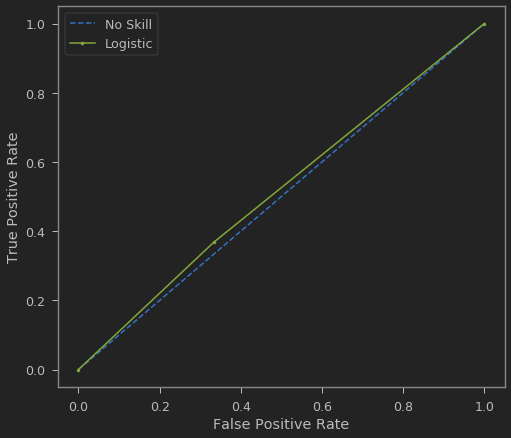

In [181]:
calculate_roc(y_test,preds[:,1])